In [1]:
import csv
import nltk
import json
import random

from nltk.corpus import stopwords
from tensorflow import keras
from keras.layers import Dropout
from keras import preprocessing
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Open dataset and append its contents to the list

In [3]:
f_hand = open("fake_reviews_dataset.csv")
csvreader = csv.reader(f_hand)

header = next(csvreader)

rows = []
for row in csvreader:
  rows.append(row)

# Preprocessing

In [4]:
# save labels and reviews in separate lists
reviews = [rev[3] for rev in rows]   
labels = [rev[2] for rev in rows]

print(reviews[:10])
print(labels[:10])
print(len(reviews))
print(len(labels))

['Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty', "love it, a great upgrade from the original.  I've had mine for a couple of years", 'This pillow saved my back. I love the look and feel of this pillow.', 'Missing information on how to use it, but it is a great product for the price!  I', 'Very nice set. Good quality. We have had the set for two months now and have not been', 'I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.', 'They are the perfect touch for me and the only thing I wish they had a little more space.', 'These done fit well and look great.  I love the smoothness of the edges and the extra', "Great big numbers & easy to read, the only thing I didn't like is the size of the", 'My son loves this comforter and it is very well made.  We also have a baby']
['CG', 'CG', 'CG', 'CG', 'CG', 'CG', 'CG', 'CG', 'CG', 'CG']
40432
40432


In [5]:
all_reviews = []                                    # a list of lists where each list is a separate review
def get_data(reviews=reviews):                        
  for review in reviews:

    stop_words = stopwords.words('english')
    # lowercase and remove stopwords
    review = [w.lower() for w in review.split() if w not in stop_words]  
    all_reviews.append(review)

In [6]:
get_data(reviews)

In [7]:
print(all_reviews[:5])
print(len(all_reviews))

[['love', 'this!', 'well', 'made,', 'sturdy,', 'comfortable.', 'i', 'love', 'it!very', 'pretty'], ['love', 'it,', 'great', 'upgrade', 'original.', "i've", 'mine', 'couple', 'years'], ['this', 'pillow', 'saved', 'back.', 'i', 'love', 'look', 'feel', 'pillow.'], ['missing', 'information', 'use', 'it,', 'great', 'product', 'price!', 'i'], ['very', 'nice', 'set.', 'good', 'quality.', 'we', 'set', 'two', 'months']]
40432


# Create word index 

In [8]:
 def create_index(filename, all_reviews=all_reviews):
  tokenizer = Tokenizer(num_words=100000) # number of tokenized words (which the model will be able to recognize)

  words = []
  for rev in all_reviews:
    for word in rev:
      words.append(word)
  tokenizer.fit_on_texts(words) 
  sequences = tokenizer.texts_to_sequences(words)
  word_index = tokenizer.word_index
  print(f"Found {len(word_index)} unique words")
    
    # save words and their indiced in a json file
  with open (filename, 'w') as f:
        json.dump(word_index, f, indent=4)

In [9]:
create_index("word_index.json", all_reviews)

Found 43591 unique words


In [10]:
#grab and return word index
def get_index(filename): 
    with open(filename, 'r') as f:
        data = json.load(f)
    return(data)

In [11]:
word_index = get_index('word_index.json')

# Padding 

In [12]:
def padding_data(sentences, index, maxlen=25):
  new_sentences = []
  for sentence in sentences:                     # in our case for sentence in all_reviews
    new_sentence = []
    words = []
    for word in sentence:
      try:
        word = index[word]
      except:
        KeyError
        word = 0
      words.append(word)  # append words converted to numbers
    new_sentence.append(words)
    new_sentence = preprocessing.sequence.pad_sequences(new_sentence, maxlen=maxlen, padding='post')
    new_sentences.append(new_sentence[0])
  return new_sentences

In [14]:
# we count the avg number of words to understand maxlen
num_words = 0
for review in all_reviews:
  length = len(review)
  num_words += length

avg = num_words / len(all_reviews)
print(avg)  

38.053225168183616


In [13]:
padded = padding_data(all_reviews, word_index, maxlen=38) 
print(padded[:2])
# maxlen is 38 because it's the average number of words in the review. It doesn't equal maximum number of words, 
# because the model doesn't show high results, I've tried that :)

[array([ 9,  0, 10,  0,  0,  0,  1,  9,  0, 85,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32), array([   9,    0,    4, 2112,    0,   52,  635,  127,  106,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)]


In [15]:
# reverse word index
def reverse_index(word_index):
    reverse_word_index = {value: key for (key, value) in word_index.items()}
    return(reverse_word_index)
    
def reconst_text(padded_revs, reverse_word_index):
    return(" ".join([reverse_word_index.get(i, "?") for i in padded_revs]))

In [16]:
reverse_word_index = reverse_index(word_index)

reconst_text(padded[0], reverse_word_index)

'love ? well ? ? ? i love ? pretty ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?'

# Labelling

In [37]:
# turn CG to 1 and OR to 0
# CG = computer generated, OR = original review
def convert_labels(lbls):
  converted_labels = []
  for label in lbls:
    if label == "CG":  
      converted_labels.append(1)
    else:
      converted_labels.append(0)
  return converted_labels

In [18]:
convert_lbls = convert_labels(labels)


In [19]:
# unite labels and sentences into total chunks
def label_data(sentences, labels):
  total_chunks = []
  for sent, lbl in zip(sentences, labels):
    chunk = (sent, lbl)
    total_chunks.append(chunk)
  return total_chunks

In [20]:
labelled = label_data(padded, convert_lbls)
print(labelled[0])

(array([ 9,  0, 10,  0,  0,  0,  1,  9,  0, 85,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32), 1)


# Split data into training and testing

In [21]:
X = np.array(padded)
y = np.array(convert_lbls)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=0.2, random_state=100)

# Create model

**DNN**

In [22]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [23]:
#create model
def create_dnn():
  model = keras.Sequential()
  model.add(keras.layers.Embedding(100000, 38))
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(keras.layers.Dense(32, activation='relu'))
  model.add(Dropout(0.1))
  model.add(keras.layers.Dense(16, activation='relu'))
  model.add(Dropout(0.1))
  model.add(keras.layers.Dense(8, activation='relu'))
  model.add(Dropout(0.1))
  model.add(keras.layers.Dense(1, activation='sigmoid',))
  model.summary()
  model.compile(optimizer='adam', loss='squared_hinge', metrics=['accuracy'])
  return(model)

In [24]:
model2 = create_dnn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 38)          3800000   
                                                                 
 global_average_pooling1d (G  (None, 38)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                1248      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

In [25]:
def train_model2(model, x_train, y_train, x_test, y_test, 
                val_size=.1, epochs=1, batch_size=32):
  vals = int(len(labelled)*val_size)
  x_val = x_train[:vals]
  x_train = x_train[vals:]
  y_val = y_train[:vals]
  y_train = y_train[vals:]
  
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr], 
                      validation_data=(x_val, y_val), 
                      verbose=1, shuffle=True)
    # plotting MAE
  plt.plot(history.history['loss'], label='MAE (training data)')
  plt.plot(history.history['val_loss'], label='MAE (validation data)')
  plt.title('MAE deep neural network')
  plt.ylabel('MAE value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

  model_results = model.evaluate(x_test, y_test)
  return model

Epoch 1/10
885/885 [==============================] - 54s 58ms/step - loss: 0.8345 - accuracy: 0.7016 - val_loss: 0.6848 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 2/10
885/885 [==============================] - 47s 53ms/step - loss: 0.6665 - accuracy: 0.8570 - val_loss: 0.6741 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 3/10
885/885 [==============================] - 48s 54ms/step - loss: 0.6351 - accuracy: 0.8859 - val_loss: 0.6782 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 4/10
885/885 [==============================] - 44s 49ms/step - loss: 0.6216 - accuracy: 0.8996 - val_loss: 0.6963 - val_accuracy: 0.8744 - lr: 0.0010


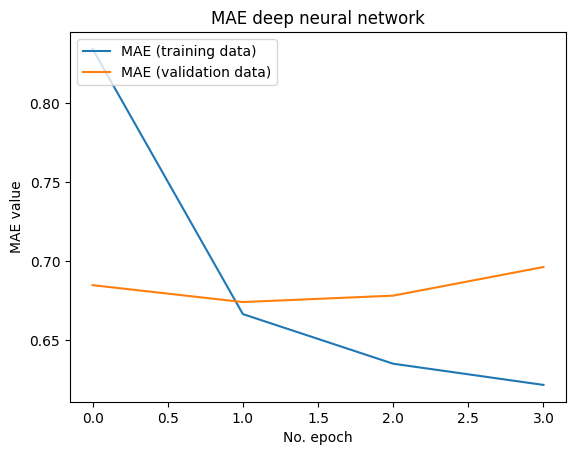

253/253 [==============================] - 1s 4ms/step - loss: 0.7027 - accuracy: 0.8688


In [26]:
model = train_model2(model2, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, epochs=10, batch_size=32)

In [27]:
model.save('models/fake_real.model')

INFO:tensorflow:Assets written to: models/fake_real.model/assets


In [28]:
model = keras.models.load_model("models/fake_real.model")

# Fucntions for applying to unseen data

In [29]:
# for preprocessing unseen text
def get_review(review):
    stop_words = stopwords.words('english')
    review = [w.lower() for w in review.split() if w not in stop_words]  
    return review

In [30]:
def padding_review(review, index, maxlen=38):
    new_review = []
    for word in review:
        try:
            word = index[word]
        except:
            KeyError
            word = 0
        new_review.append(word)

    new_reviews = []
    new_reviews.append(new_review)
    new_reviews = preprocessing.sequence.pad_sequences(new_reviews, maxlen=maxlen, padding='post')
    return new_reviews

In [31]:
# predict
def predict_rev(text):
    text = get_review(text)
    test_padded = padding_review(text, word_index, maxlen=38)
    test_array = np.array(test_padded)
    prediction = model.predict(test_array)
    return prediction
    

# Predict all reviews

In [33]:
file = "Cell_Phones_&_Accessories.txt"
f_hand = open(file, "r+", encoding="UTF-8")
contents = f_hand.readlines()
reviews = [contents[x:x+11] for x in range(0, len(contents), 11)]  #each review block is now a separate dictionary

In [38]:
# save reviews predicted as fake or real in separate lists
fake_reviews = []
real_reviews = []

for rev in reviews[:500]:
    new_str = " ".join([item for item in rev])
    
    rev_text = rev[9][12:]
    predicted = predict_rev(rev_text)
    if predicted >= .5:
        fake_reviews.append(new_str)
    elif predicted < .5:
        real_reviews.append(new_str)
        

In [42]:
fake = 100 / (500 / len(fake_reviews))
real = 100 / (500 / len(real_reviews))
print(fake, real)

10.799999999999999 89.2


Conclusion: 

I have tested this model only on 500 reviews as far as the number of all reviews is too large and it takes pretty much time. If we take this sample of 500 reviews, we can see that about 11% of reviews are predicted by the model as fake ones. Meaning both people reading reviews on a certain products as well as websites selling products of other companies should pay attention to the fact that about 11% of reviews left on such websites are misleading because they are computer generated. 